In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import os
import warnings
import talib
import pairs
import backtest
from pair_statistics import Statistics

In [2]:
# System Setting
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%4f' % x)
warnings.filterwarnings('ignore')


In [3]:
###########################
#       Data Loading      #
###########################
root_path = './pickle'
ticker_pkl = 'kse_18_20_ticker.pkl'
sector_pkl = 'kse_sector.pkl'
# price_pkl = 'kse_11_20_volume.pkl'
price_pkl = 'kse_01_20_volume.pkl'

ticker_pkl = os.path.join(root_path, ticker_pkl)
sector_pkl = os.path.join(root_path, sector_pkl)
price_pkl = os.path.join(root_path, price_pkl)

ticker_series = pd.read_pickle(ticker_pkl)
sector_df = pd.read_pickle(sector_pkl)
df_ori = pd.read_pickle(price_pkl)

In [4]:
Close = df_ori['수정주가(원)']
Volume = df_ori['거래량(주)']
Cap = df_ori['시가총액 (52주 평균)(백만원)']
(Close.isnull().sum()).equals(Volume.isnull().sum())

True

## Data Generation for Machine Learning

In [109]:
# Moving Average
ma5 = Close.rolling(window=5).mean()
ma20 = Close.rolling(window=20).mean()
ma60 = Close.rolling(window=60).mean()
ma120 = Close.rolling(window=120).mean()

# Exponential Moving Average
ema5 = Close.apply(lambda x : talib.func.EMA(x,5),axis=0)
ema20 = Close.apply(lambda x : talib.func.EMA(x,20),axis=0)
ema60 = Close.apply(lambda x : talib.func.EMA(x,60),axis=0)
ema120 = Close.apply(lambda x : talib.func.EMA(x,120),axis=0)

# Bollinger Bands
mstd20 = Close.rolling(window=20).std()
bb_up = ma20 + mstd20*2
bb_dn = ma20 - mstd20*2
# bb_up = Close.apply(lambda x: talib.BBANDS(x, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)[0], axis=0)
# bb_dn = Close.apply(lambda x: talib.BBANDS(x, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)[2], axis=0)

# RSI
rsi14 = Close.apply(lambda x: talib.RSI(x, 14), axis=0)

# MACD
macd = Close.apply(lambda x: talib.MACD(x, 12, 26, 9)[0])
# macd_sig = Close.apply(lambda x: talib.MACD(x, 12, 26, 9)[1])


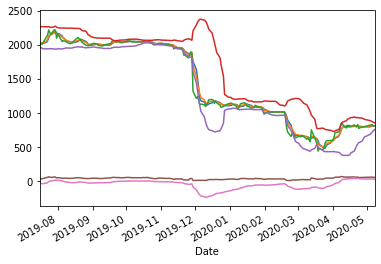

In [110]:
ma5.iloc[-200:, 1].plot()
ema_5.iloc[-200:, 1].plot()
Close.iloc[-200:, 1].plot()
bb_up.iloc[-200:, 1].plot()
bb_dn.iloc[-200:, 1].plot()
rsi14.iloc[-200:, 1].plot()
macd.iloc[-200:, 1].plot()
# macd_sig.iloc[-200:, 1].plot()

## Set Formation and Trading Period

In [111]:
d = datetime.datetime(2011, 1, 1)
df = df_ori.loc[df_ori.index > d, :]
rolling_window = 130
from_trade = 252

formation_start_date = [df.index.values[i+1].astype('M8[D]') for i in range(0, len(df), rolling_window)]
trading_start_date = [df.index.values[i+1].astype('M8[D]') for i in range(from_trade, len(df) , rolling_window)]
trading_start_date

[numpy.datetime64('2012-01-09'),
 numpy.datetime64('2012-07-18'),
 numpy.datetime64('2013-01-25'),
 numpy.datetime64('2013-08-02'),
 numpy.datetime64('2014-02-17'),
 numpy.datetime64('2014-08-26'),
 numpy.datetime64('2015-03-11'),
 numpy.datetime64('2015-09-15'),
 numpy.datetime64('2016-03-29'),
 numpy.datetime64('2016-10-10'),
 numpy.datetime64('2017-04-14'),
 numpy.datetime64('2017-10-31'),
 numpy.datetime64('2018-05-11'),
 numpy.datetime64('2018-11-22'),
 numpy.datetime64('2019-06-05'),
 numpy.datetime64('2019-12-12')]

In [112]:
year_list = df.index.year.unique()
trading_period = relativedelta(months=6)
formation_period = relativedelta(months=12)
total_period = trading_period + formation_period

formation_str_list = ([datetime.datetime(y, 1, 1) for y in year_list if datetime.datetime(y, 1, 1) + total_period < df.index[-1]] + 
                        [datetime.datetime(y, 7, 1) for y in year_list if datetime.datetime(y, 7, 1) + total_period < df.index[-1]])
formation_str_list = sorted(formation_str_list)
trading_str_list = [x + formation_period for x in formation_str_list]
trading_str_list
formation_end_list = [x + formation_period + relativedelta(days=-1) for x in formation_str_list]
trading_end_list = [x + trading_period + relativedelta(days=-1) for x in trading_str_list]
formation_str_list

[datetime.datetime(2011, 1, 1, 0, 0),
 datetime.datetime(2011, 7, 1, 0, 0),
 datetime.datetime(2012, 1, 1, 0, 0),
 datetime.datetime(2012, 7, 1, 0, 0),
 datetime.datetime(2013, 1, 1, 0, 0),
 datetime.datetime(2013, 7, 1, 0, 0),
 datetime.datetime(2014, 1, 1, 0, 0),
 datetime.datetime(2014, 7, 1, 0, 0),
 datetime.datetime(2015, 1, 1, 0, 0),
 datetime.datetime(2015, 7, 1, 0, 0),
 datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 7, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 7, 1, 0, 0),
 datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 7, 1, 0, 0)]

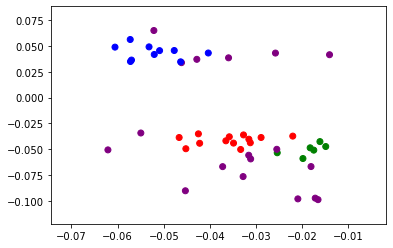

In [95]:
d = classified_list[6]
factor_sig = d.iloc[0, :]
k = factor_sig.sum()
tc = factor_sig == True
target_tickers = d.index
# kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=1)
kmeans_pca = OPTICS()
kmeans_pca.fit(df_params.loc[target_tickers, factor_sig == True])
d['cluster'] = kmeans_pca.labels_
colors = ['blue', 'red', 'green', 'orange', 'purple']
clist = [colors[x] for x in d['cluster']]
plt.scatter(df_params.loc[target_tickers, tc].iloc[:, 0], df_params.loc[target_tickers, tc].iloc[:, 1], c=clist)

In [13]:
st = main(formation_close, trading_close)

ValueError: Found array with 0 feature(s) (shape=(15, 0)) while a minimum of 1 is required.

In [9]:
i = 3
fs, fe, ts, te = formation_str_list[i], formation_end_list[i], trading_str_list[i], trading_end_list[i]
df_price = df.loc[fs:te, '수정주가(원)'].copy()
df_price = df_price.dropna(axis=1)

formation_close = df_price[fs:fe]
trading_close = df_price[ts:te]
rt = main(formation_close, trading_close)
rt

ValueError: min_samples must be no greater than the number of samples (2). Got 5

In [8]:
st_list = []
for fs, fe, ts, te in zip(formation_str_list, formation_end_list, trading_str_list, trading_end_list):
    df_price = df.loc[fs:te, '수정주가(원)'].copy()
    df_price = df_price.dropna(axis=1)
    
    formation_close = df_price[fs:fe]
    trading_close = df_price[ts:te]
    st = main(formation_close, trading_close)
    st_list.append(st)

Finding Pairs from 0 Cluster(75 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 2 Cluster(26 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 3 Cluster(31 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 4 Cluster(33 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 5 Cluster(49 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 6 Cluster(29 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pa

Finding Pairs from 22 Cluster(9 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 23 Cluster(3 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 25 Cluster(3 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 26 Cluster(3 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
Date: 2013-01-02 00:00:00 ~ 2013-06-28 00:00:00
# of Date: 123
# of Pairs: 50
Mean: 0.9727
Standard Deviation: 0.1827
Skewness: 0.1936
Kurtosis: 0.7835
Min: 0.5491
Max: 1.4517
Observation with Excess Return > 1: 20 (0.40%)
Observation with Excess Return < 1: 26 (0.52%)
Observation with Excess Return = 1: 4 (0.08%)
Sharpe Ratio: -1.9866
Finding Pairs from 0 Cluster(107 stocks in the cluster)..
	Finding Pairs f

	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 11 Cluster(14 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 12 Cluster(63 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 14 Cluster(14 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 15 Cluster(18 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 16 Cluster(7 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 17 Clust

Date: 2015-07-01 00:00:00 ~ 2015-12-30 00:00:00
# of Date: 126
# of Pairs: 46
Mean: 1.0331
Standard Deviation: 0.1707
Skewness: 1.3473
Kurtosis: 2.9687
Min: 0.6779
Max: 1.6412
Observation with Excess Return > 1: 18 (0.39%)
Observation with Excess Return < 1: 17 (0.37%)
Observation with Excess Return = 1: 11 (0.24%)
Sharpe Ratio: 0.5599
Finding Pairs from 0 Cluster(37 stocks in the cluster)..
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 3 Cluster(29 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 4 Cluster(41 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 5 Cluster(19 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	F

	Finding Pairs from 1 Small Cluster
Finding Pairs from 13 Cluster(34 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 14 Cluster(20 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 4 Small Cluster
Finding Pairs from 17 Cluster(10 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 18 Cluster(17 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 2 Small Cluster
Date: 2017-01-02 00:00:00 ~ 2017-06-30 00:00:00
# of Date: 122
# of Pairs: 66
Mean: 1.0108
Standard Deviation: 0.1516
Skewness: 0.3689
Kurtosis: 1.6501
Min: 0.6068
Max: 1.4592
Observation with Excess Return > 1: 30 (0.45%)
Obser

	Finding Pairs from 3 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 8 Cluster(36 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 3 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 10 Cluster(40 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
Finding Pairs from 11 Cluster(41 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 12 Cluster(5 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 13 Cluster(51 stocks in the cluster)..
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 14 Cluster(19 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Findi

In [8]:
def main(formation_close, trading_close):
    ###########################
    #      Finding Pairs      #
    ###########################
    str_date = str(formation_close.index[0].date())
    end_date = str(trading_close.index[-1].date())
    pickle_name = 'pickle/pairs_{}~{}11.pkl'.format(str_date, end_date)
    if not os.path.isfile(pickle_name):
        df_pairs = pairs.find_pairs(formation_close)
        # df_pairs.to_pickle(pickle_name)
    else:
        print('Get Pairs from Pickle...')
        df_pairs = pd.read_pickle(pickle_name)

    ###########################
    #    Trading with Pairs   #
    ###########################
    ret_df = pd.DataFrame()
    for i in range(len(df_pairs)):
        # print(i)
        trading_history, _ = backtest.get_pair_returns(df_pairs.loc[i, :], formation_close, trading_close)
        ret_df[i] = trading_history['quantity_neutral']

    ###########################
    #        Statistics       #
    ###########################
    Statistics(ret_df).print_statistics()


In [128]:
main(formation_close, trading_close)

<built-in method date of Timestamp object at 0x000001FBC9075E48>
Finding Pairs from 0 Cluster(74 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 1 Cluster(26 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 2 Cluster(14 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 3 Cluster(12 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 4 Cluster(44 stocks in the cluster)..
	Finding Pairs from 4 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 5 Cluster(59 stocks

In [114]:
###########################
#   Data Pre-processing   #
###########################
# df = df.dropna(axis=1)
form_str_date = datetime.datetime(2018, 1, 1)
form_end_date = datetime.datetime(2018, 12, 31)
trading_str_date = datetime.datetime(2019, 1, 1)
trading_end_date = datetime.datetime(2019, 6, 30)

df_price = df.loc[form_str_date:trading_end_date, '수정주가(원)'].copy()
df_price = df_price.dropna(axis=1)


formation_close = df_price[form_str_date:form_end_date]
trading_close = df_price[trading_str_date:trading_end_date]

# Preprocessing for ML


In [14]:
###########################
#      Finding Pairs      #
###########################
if not os.path.isfile('pickle/pairs3.pkl'):
    df_pairs = pairs.find_pairs(formation_close)
    # df_pairs.to_pickle('pickle/pairs.pkl')
else:
    print('Reading Pairs Pickle...')
    df_pairs = pd.read_pickle('pickle/pairs.pkl')
df_pairs

Finding Pairs from 0 Cluster(74 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 1 Cluster(26 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 2 Small Cluster
Finding Pairs from 2 Cluster(14 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 0 Small Cluster
Finding Pairs from 3 Cluster(12 stocks in the cluster)..
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 4 Cluster(44 stocks in the cluster)..
	Finding Pairs from 4 Small Cluster
	Finding Pairs from 2 Small Cluster
	Finding Pairs from 0 Small Cluster
	Finding Pairs from 1 Small Cluster
	Finding Pairs from 3 Small Cluster
Finding Pairs from 5 Cluster(59 stocks in the cluster)..
	Finding Pairs from 2 Small Cluster
	Finding P

,alpha,beta,cluster,pval,r2,s1,s2
0,0,0.580273,0_2,0.000160,0.992531,A001120,A204320
1,0,5.830326,0_2,0.001087,0.986854,A139480,A204320
2,0,0.256983,0_2,0.001640,0.998702,A026960,A072710
3,0,1.470591,0_2,0.003567,0.987157,A004000,A204320
4,0,0.042917,0_2,0.009607,0.988355,A013570,A086280
5,0,1.874509,1_1,0.000024,0.994260,A018260,A035720
6,0,21.902222,1_1,0.000062,0.996088,A018260,A042700
7,0,19.232604,1_1,0.002469,0.991619,A005930,A000040
8,0,2.062287,1_1,0.005559,0.996277,A005930,A023590
9,0,1.772247,1_1,0.006559,0.989740,A011790,A023590


In [15]:
###########################
#    Trading with Pairs   #
###########################
ret_df = pd.DataFrame()
for i in range(len(df_pairs)):
    a, c = backtest.get_pair_returns(df_pairs.loc[i, :], formation_close, trading_close)
    ret_df[i] = a['quantity_neutral']
ret_df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1
2019-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,1
2019-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1,1.000000,0.978586,1.000000,1.000000,1
2019-01-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.027620,1.000000,1.000000,1
2019-01-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1,1.000000,1.048166,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,1.000000,0.988418,1.000000,1.030192,1.008180,0.991213,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.988483,1.087613,1,1.000000,1.000000,1.000000,1.000000,1
2019-06-25,1.000000,0.998084,1.000000,0.974094,0.977007,0.985959,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.999399,0.991743,1,1.000000,1.000000,1.000000,1.000000,1
2019-06-26,1.000000,0.995140,1.000000,1.001761,0.983744,1.006361,1,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.012636,0.999688,1,1.000000,1.000000,1.000000,1.000000,1


In [16]:
###########################
#        Statistics       #
###########################
Statistics(ret_df).print_statistics()

Date: 2019-01-02 00:00:00 ~ 2019-06-28 00:00:00
# of Date: 121
# of Pairs: 46
Mean: 1.0262
Standard Deviation: 0.1030
Skewness: -0.0609
Kurtosis: 0.5319
Min: 0.7659
Max: 1.2610
Observation with Excess Return > 1: 24 (0.52)
Observation with Excess Return < 1: 14 (0.30)
Observation with Excess Return = 1: 8 (0.17)
Sharpe Ratio: 0.2999


In [8]:
ma5 = formation_close.rolling(window=5).mean()
ma10 = Close.rolling(window=10).mean()['2007-02-08':]    
ema_26 = Close.apply(lambda x : func.EMA(x,26),axis=0)['2007-02-08':]
ema_12 = Close.apply(lambda x : func.EMA(x,12),axis=0)['2007-02-08':]
sd_10 = Close.rolling(10).std()['2007-02-08':]
bb_up = (ma5+sd_10*2)['2007-02-08':]
bb_low = (ma5-sd_10*2)['2007-02-08':]
ema = Close.ewm(com=0.5).mean()['2007-02-08':]

ma5_open = Open.rolling(window=5).mean()['2007-02-08':] 
ma10_open = Open.rolling(window=10).mean()['2007-02-08':]    
ema_26_open = Open.apply(lambda x : func.EMA(x,26),axis=0)['2007-02-08':]
ema_12_open = Open.apply(lambda x : func.EMA(x,12),axis=0)['2007-02-08':]
sd_10_open = Open.rolling(10).std()['2007-02-08':]
bb_up_open = (ma5_open+sd_10_open*2)['2007-02-08':]
bb_low_open = (ma5_open-sd_10_open*2)['2007-02-08':]
ema_open = Open.ewm(com=0.5).mean()['2007-02-08':]

NameError: name 'Close' is not defined

In [31]:
formation_close.rolling(window=1)

Rolling [window=1,center=False,axis=0]

In [21]:
for a in formation_close.rolling(window=5):
    print(a)

NotImplementedError: See issue #11704 https://github.com/pandas-dev/pandas/issues/11704